In [1]:
import pandas as pd
import numpy as np
import json
import pandas as pd
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import pickle
from tqdm import tqdm 
from ast import literal_eval
import cobra
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

import gurobipy
gurobipy.setParam('OutputFlag', 0)
import sys
sys.path.append('../retrosynthesis/')

from common import *


### input and output

In [2]:
###input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/Yeast-MetaTwin.yml'


biolog_data_path = '../../Data/Biolog_Substrate.tsv'

###output
biolog_confusion_matrix_figure_path = '../../Results/Figures/figs6-c.pdf'

In [4]:
def get_accuracy_and_confusion_matrix_num(essential_predict_list,notessential_predict_list,essential_genes,not_essential_genes):
    TP = len(set(essential_predict_list) & set(essential_genes))
    TN = len(set(notessential_predict_list) & set(not_essential_genes))
    FP = len(set(essential_predict_list) - set(essential_genes))
    FN = len(set(notessential_predict_list) - set(not_essential_genes))
    Accuracy = round((TP + TN) / (TP + TN + FP + FN), 3)
    print(Accuracy)
    return TP,TN,FP,FN,Accuracy

In [5]:
def get_yeast8_id_from_name(name,model):
    met_id = ''
    if met_id == '':
        for i in model.metabolites:
            if i.name == name and i.compartment=='e':
                met_id = i.id
                break
    return met_id

In [6]:
def get_exchange_reaction(Target_met,model):
    if Target_met!='':
        exchange_reaction = ''
        for i in model.reactions:
            if Target_met in i.reaction and len(i.metabolites) == 1:
                exchange_reaction = i.id
        if exchange_reaction == '':
            reaction_name = 'DM_'+ Target_met
            reaction = Reaction(reaction_name)
            reaction.name = reaction_name
            reaction.subsystem = ''
            reaction.lower_bound = 0.  # This is the default
            reaction.upper_bound = 1000.  # This is the default

            reactant_met_num = {Target_met:-1}
            for met_id, coeff in reactant_met_num.items():
                met = model.metabolites.get_by_id(met_id)
                if met:
                    reaction.add_metabolites({met: coeff})
            model.add_reactions([reaction])  
            exchange_reaction = reaction_name     
        return(exchange_reaction)
    else:
        pass

In [7]:
def biology_simulation(Target_met,Substrate_type,model):
    if Target_met!='':
        if Substrate_type == 'C':
            with model:
                model.reactions.get_by_id('r_1714').bounds = (0,0)
                exchange_reaction = get_exchange_reaction(Target_met,model)
                model.reactions.get_by_id(exchange_reaction).bounds = (-5,1000)
                model.solver = 'gurobi'
                model.optimize()
                if model.reactions.get_by_id('r_2111').flux > 0.00001:
                    return 'G'
                else:
                    return 'NG'

        elif Substrate_type == 'N':
            with model:
                model.reactions.get_by_id('r_1654').bounds = (0,0)
                exchange_reaction = get_exchange_reaction(Target_met,model)
                model.reactions.get_by_id(exchange_reaction).bounds = (-5,1000)
                model.solver = 'gurobi'
                model.optimize()
                if model.reactions.get_by_id('r_2111').flux > 0.00001:
                    return 'G'
                else:
                    return 'NG'

        elif Substrate_type == 'P':
            with model:
                model.reactions.get_by_id('r_2005').bounds = (0,0)
                exchange_reaction = get_exchange_reaction(Target_met,model)
                model.reactions.get_by_id(exchange_reaction).bounds = (-5,1000)
                model.solver = 'gurobi'
                model.optimize()
                if model.reactions.get_by_id('r_2111').flux > 0.00001:
                    return 'G'
                else:
                    return 'NG'

        elif Substrate_type == 'S':
            with model:
                model.reactions.get_by_id('r_2060').bounds = (0,0)
                exchange_reaction = get_exchange_reaction(Target_met,model)
                model.reactions.get_by_id(exchange_reaction).bounds = (-5,1000)
                model.solver = 'gurobi'
                model.optimize()
                if model.reactions.get_by_id('r_2111').flux > 0.00001:
                    return 'G'
                else:
                    return 'NG'
        else:
            print('error')      
    else:
        return 'NG'

In [8]:
def yeast8_yeast8U_biolog_simulation(biolog_data_path,yeast870_path,yeast8U_path):
    yeast8 = cobra.io.load_yaml_model(yeast870_path)
    yeast8U = cobra.io.load_yaml_model(yeast8U_path)

    biolog_data = pd.read_csv(biolog_data_path,sep='\t')
    biolog_data['yeast8_id'] = biolog_data['Name_in_Model'].apply(lambda x:get_yeast8_id_from_name(x,yeast8))

    biolog_data['biology_simulation'] = biolog_data.apply(lambda x: biology_simulation(x['yeast8_id'], x['Substrate_type'], yeast8), axis=1)
    biolog_data['biology_simulation_plus'] = biolog_data.apply(lambda x: biology_simulation(x['yeast8_id'], x['Substrate_type'], yeast8U), axis=1)
    return biolog_data

In [9]:
biolog_data_with_simulation = yeast8_yeast8U_biolog_simulation(biolog_data_path,yeast870_path,yeast8U_path)
biolog_data_with_simulation.head(3)

/home/wuke/anaconda3/envs/kcat/lib/python3.7/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,Substrate,Name_in_Model,Substrate_type,Growth_Biolog,Growth_Model,yeast8_id,biology_simulation,biology_simulation_plus
0,L-Malic Acid,(S)-malate,C,NG,G,s_0067,G,G
1,L-Glutamic Acid,L-glutamate,C,NG,G,s_0992,G,G
2,Thymidine,thymidine,C,NG,NG,s_1494,NG,NG


In [10]:
yeast8_TP = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='G')&(biolog_data_with_simulation['biology_simulation']=='G')])
yeast8_TN = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='NG')&(biolog_data_with_simulation['biology_simulation']=='NG')])
yeast8_FP = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='NG')&(biolog_data_with_simulation['biology_simulation']=='G')])
yeast8_FN = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='G')&(biolog_data_with_simulation['biology_simulation']=='NG')])
yeast8_Accuracy = round((yeast8_TP + yeast8_TN) / (yeast8_TP + yeast8_TN + yeast8_FP + yeast8_FN), 3)
print(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy)

yeast8U_TP = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='G')&(biolog_data_with_simulation['biology_simulation_plus']=='G')])
yeast8U_TN = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='NG')&(biolog_data_with_simulation['biology_simulation_plus']=='NG')])
yeast8U_FP = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='NG')&(biolog_data_with_simulation['biology_simulation_plus']=='G')])
yeast8U_FN = len(biolog_data_with_simulation[(biolog_data_with_simulation['Growth_Biolog']=='G')&(biolog_data_with_simulation['biology_simulation_plus']=='NG')])
yeast8U_Accuracy = round((yeast8U_TP + yeast8U_TN) / (yeast8U_TP + yeast8U_TN + yeast8U_FP + yeast8U_FN), 3)
print(yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy)

116 197 41 29 0.817
117 191 47 28 0.804


In [18]:
def draw_confusion_matrix_figure(yeast8_TP, yeast8_TN, yeast8_FP, yeast8_FN, yeast8_Accuracy, 
                                 yeast8U_TP, yeast8U_TN, yeast8U_FP, yeast8U_FN, yeast8U_Accuracy, 
                                 figure_path, vmax):
    # Assume you have two sets of confusion matrix data
    confusion_matrix1 = np.array([[yeast8_TP, yeast8_FP], [yeast8_FN, yeast8_TN]])
    confusion_matrix2 = np.array([[yeast8U_TP, yeast8U_FP], [yeast8U_FN, yeast8U_TN]])

    # Create a figure, set the subplot layout to 1 row and 2 columns, with the right subplot being narrower
    fig = plt.figure(figsize=(2, 1.6), dpi=400)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['pdf.fonttype'] = 42
    
    gs = GridSpec(1, 3, width_ratios=[0.6, 0.6, 0.03])

    # First subplot
    ax1 = plt.subplot(gs[0])
    im1 = ax1.imshow(confusion_matrix1, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.grid(False)
    ax1.text(0, 0, f"TP\n{confusion_matrix1[0, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(1, 0, f"FP\n{confusion_matrix1[0, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(0, 1, f"FN\n{confusion_matrix1[1, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax1.text(1, 1, f"TN\n{confusion_matrix1[1, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax1.set_xlabel(f"Yeast8\n(ACC = {yeast8_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Second subplot
    ax2 = plt.subplot(gs[1])
    im2 = ax2.imshow(confusion_matrix2, cmap='Wistia', interpolation='nearest', vmin=1, vmax=vmax, aspect=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)
    ax2.text(0, 0, f"TP\n{confusion_matrix2[0, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(1, 0, f"FP\n{confusion_matrix2[0, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(0, 1, f"FN\n{confusion_matrix2[1, 0]}", ha='center', va='center', fontsize=8, color='black')
    ax2.text(1, 1, f"TN\n{confusion_matrix2[1, 1]}", ha='center', va='center', fontsize=8, color='black')
    ax2.set_xlabel(f"Yeast-MetaTwin\n(ACC = {yeast8U_Accuracy:.2f})", fontsize=8, labelpad=-1)
    # Add border to the image
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Color bar
    cbar_ax = plt.subplot(gs[2])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
    # Add border to the image
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.02)
    # Save the image to a file
    plt.savefig(figure_path, dpi=400, bbox_inches='tight')
    plt.show()

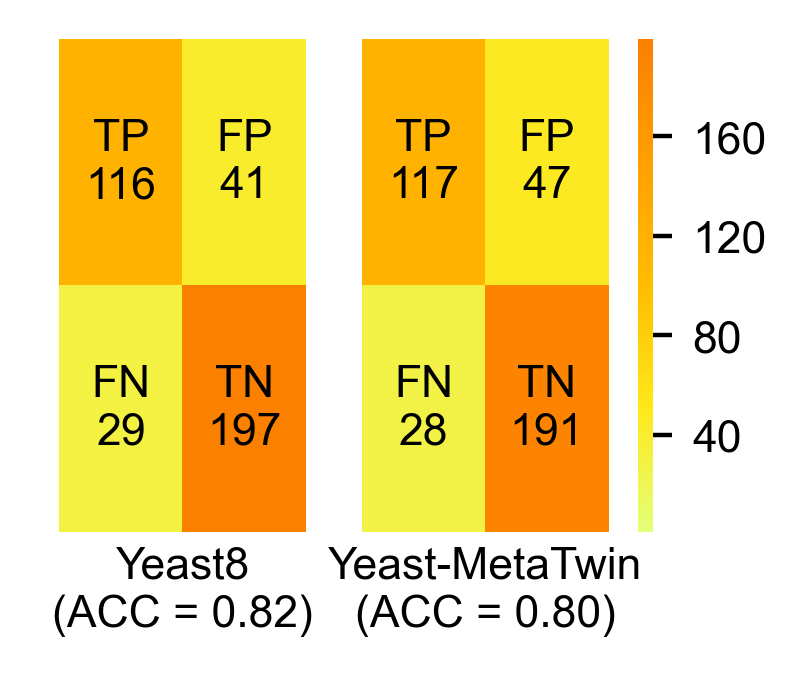

In [19]:
draw_confusion_matrix_figure(yeast8_TP,yeast8_TN,yeast8_FP,yeast8_FN,yeast8_Accuracy,yeast8U_TP,yeast8U_TN,yeast8U_FP,yeast8U_FN,yeast8U_Accuracy,biolog_confusion_matrix_figure_path,vmax=199)